## Try bifurcation case

In [1]:
import torch 
import numpy as np

from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

from data.budworm import simulate_trials
from stabnode.utils import set_global_seed
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')


seed = 1234
set_global_seed(seed=seed)


savefigs = True
folder = "figures_bifurcation/"

In [2]:
# plt.style.available

## Control Function and $k_i$ trial values

In [3]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

def smooth_k_torch(t):
    A = (k2-k1)/2
    return A*torch.sin(t-torch.pi/2) + A + k1

6.44569072482332 9.93441120446710


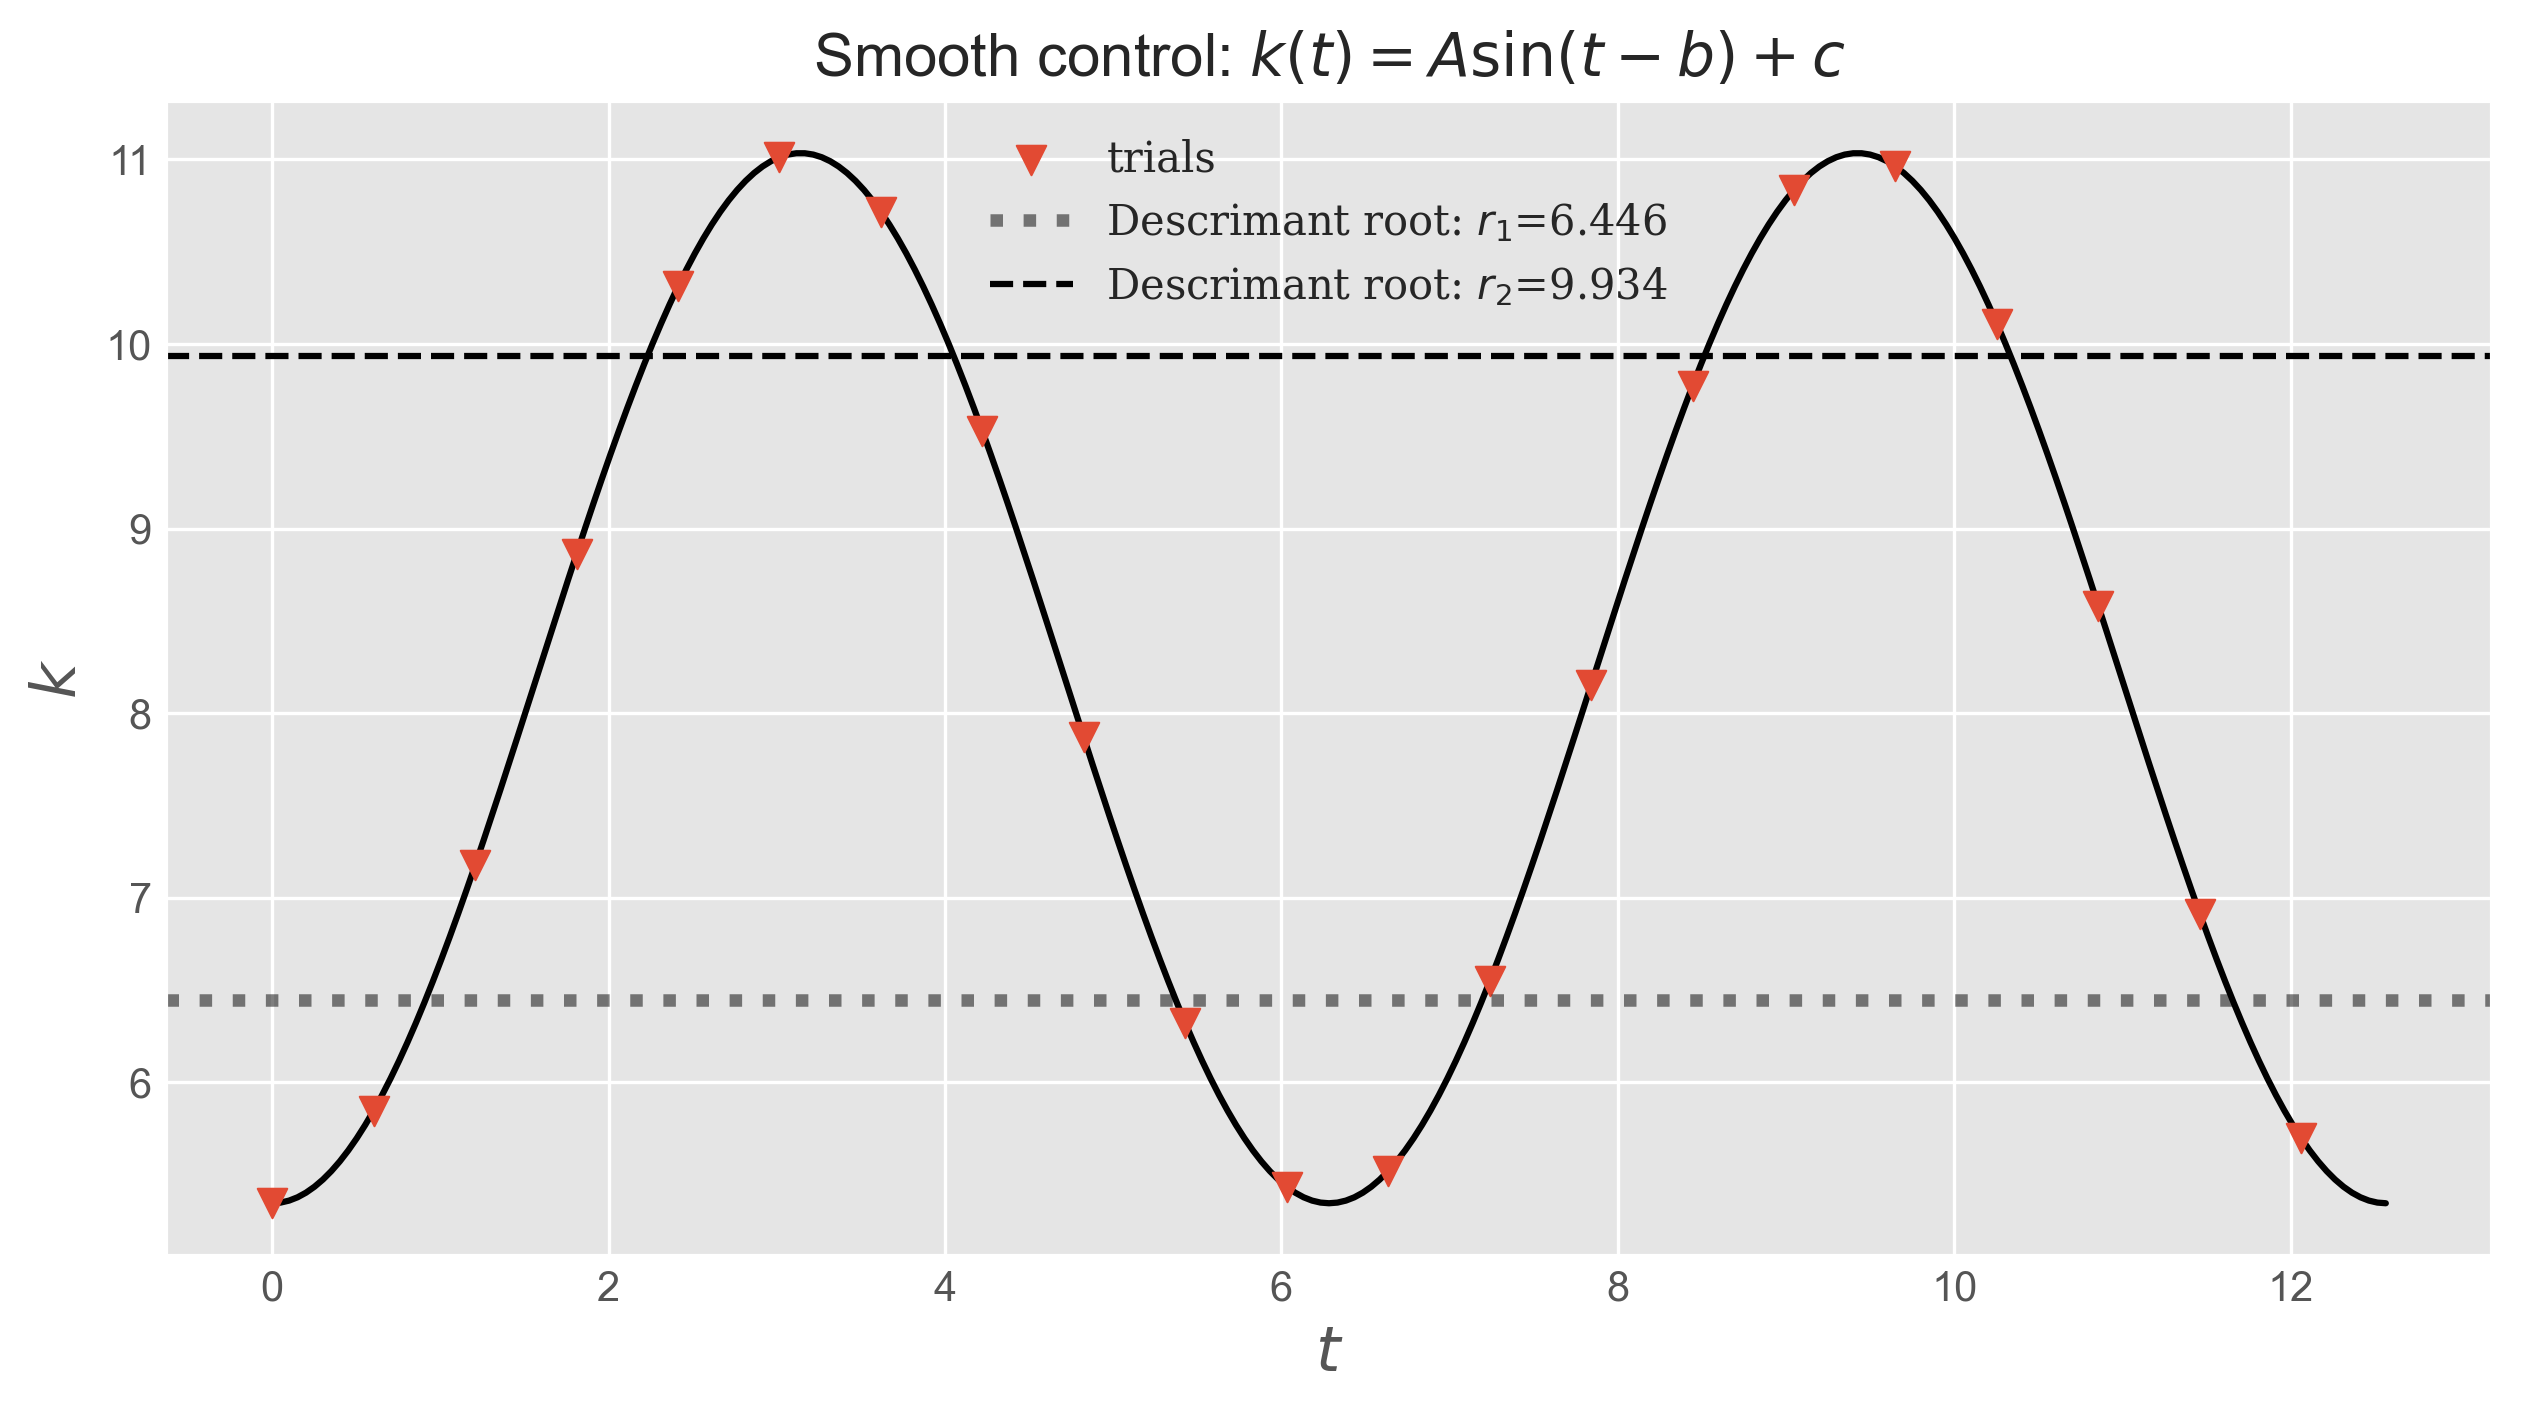

In [4]:
sample_rate = 12
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=300)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)
ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}")
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
if savefigs:
    plt.savefig(folder+f"budworm_smooth_control_{len(k_trials)}_k_trials.pdf")
plt.grid(True)
plt.show()

## Single trajectory for each $k_i$ trial

In [5]:

bw_trials = simulate_trials(k_trials,x0=2, dt=0.2,r=0.56, eps=1e-4,buffer=1e-1,t_max=400,n_points=501,show_progress=True)
bw_trials

  0%|          | 0/21 [00:00<?, ?it/s]

BudwormTrials contents:
  x_vals: (len=21)
  t_vals: (len=21)
  k_vals: (len=21)
  x_stars: (len=21)
  t_stars: (len=21)
  indices: (len=21)
  dt: 0.2

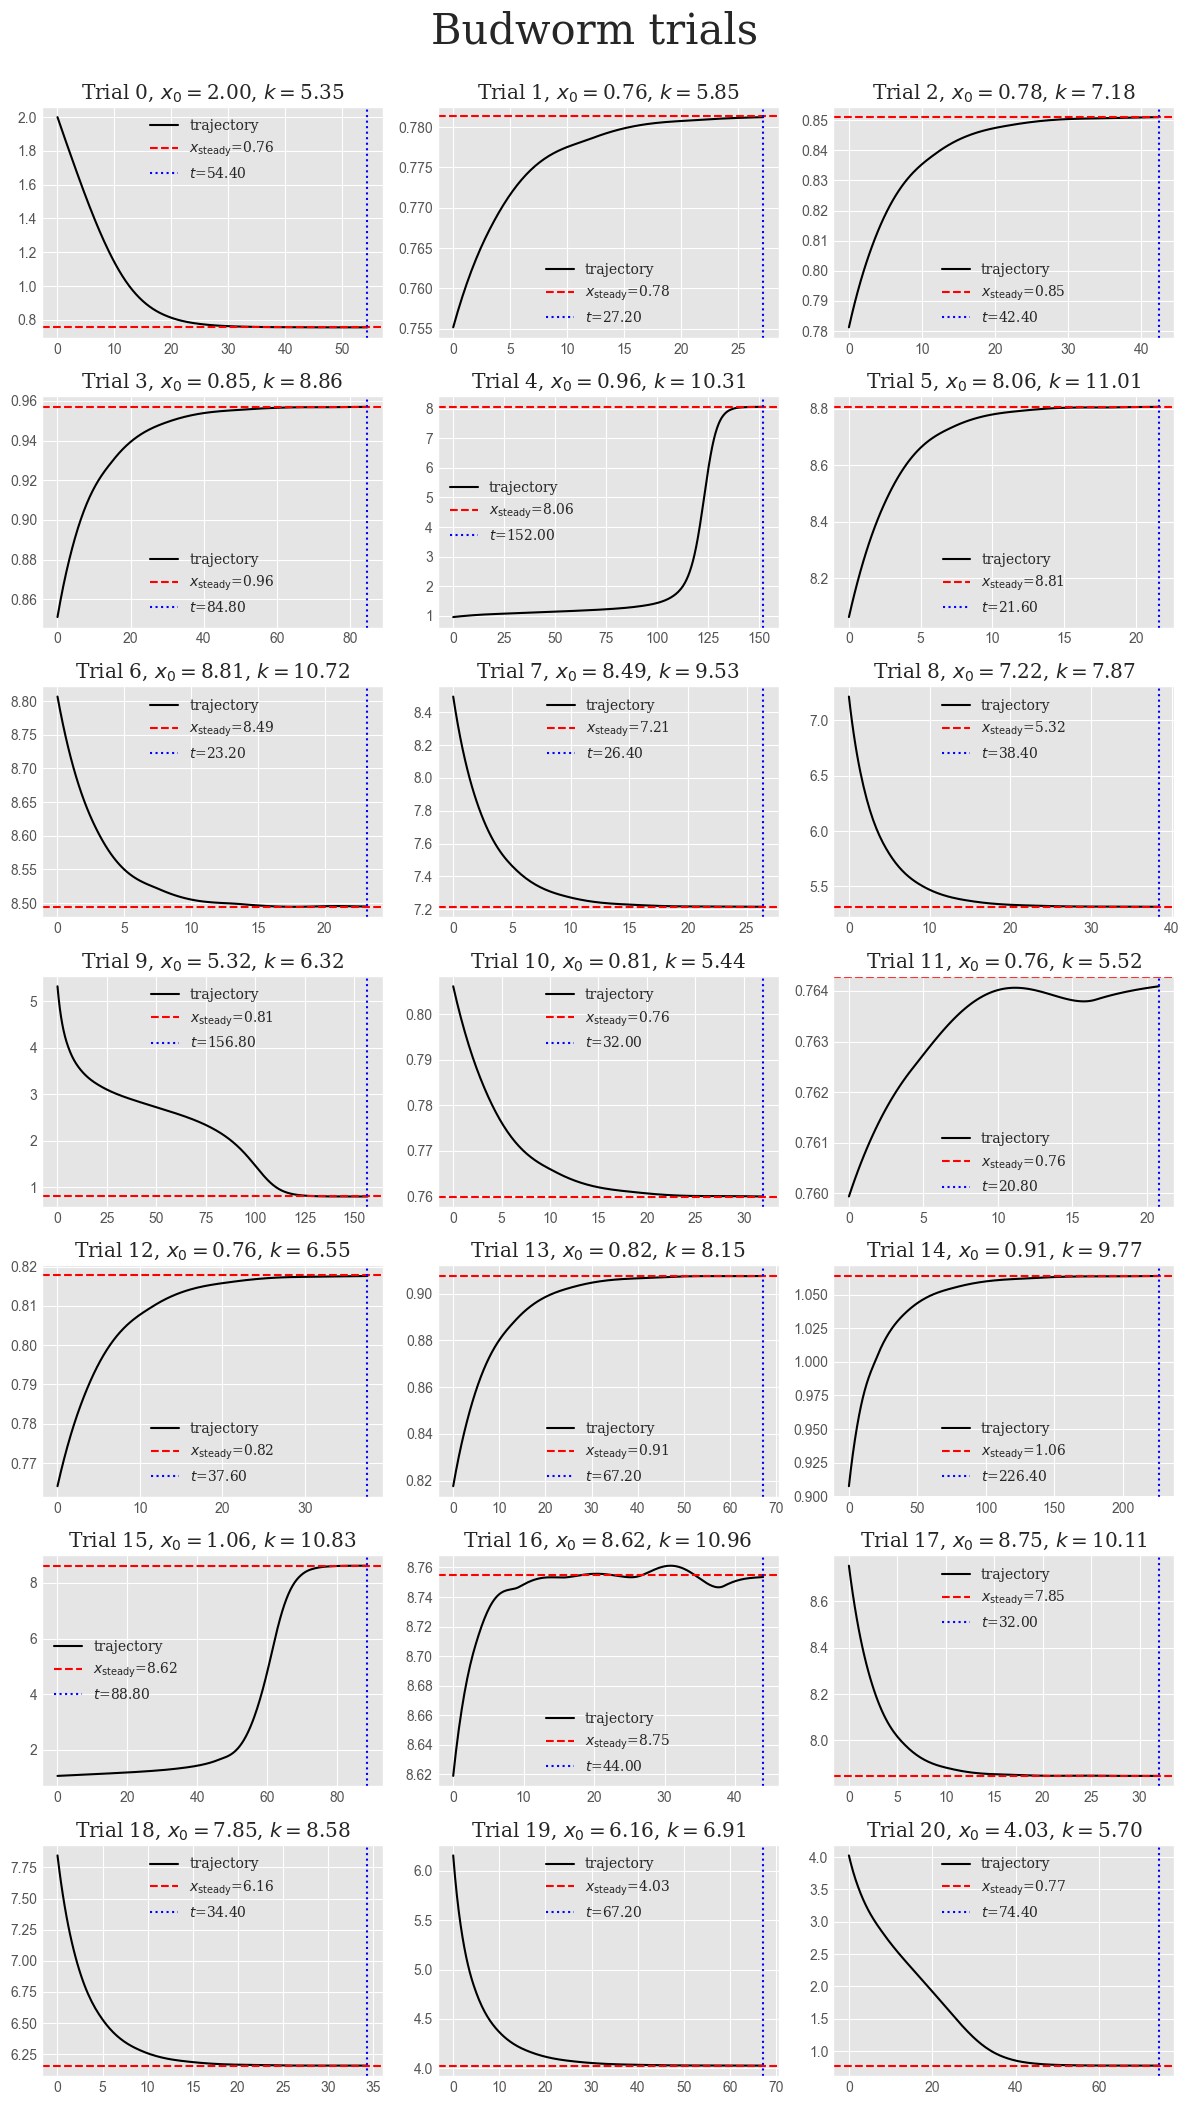

In [6]:
precision = 2
n_plots = len(bw_trials.x_stars)
cols = 3
rows = int(np.ceil(n_plots/cols))

fig, axs = plt.subplots(rows, cols, figsize = (cols*4,rows*3))
axs = axs.flatten()
for idx in range(n_plots):
    x = bw_trials.x_vals[idx]
    t = bw_trials.t_vals[idx]
    xs = bw_trials.x_stars[idx]
    ts = bw_trials.t_stars[idx]

    ax = axs[idx]
    ax.plot(t,x,c='black', label='trajectory')
    ax.axhline(xs,linestyle='--',c='red', label=r"$x_{\text{steady}}$"+f"={xs:.{precision}f}")
    ax.axvline(ts, linestyle=':',c='blue', label=r"$t$="+f"{ts:.{precision}f}")
    ax.legend(prop={'family':'serif'})
    ax.set_title(f"Trial {idx}, "+rf"$x_0=${x[0]:.{precision}f}, " + rf"$k=${k_trials[idx]:.{precision}f}",family='serif')

for idx in range(n_plots,rows*cols):
    fig.delaxes(axs[idx])
fig.suptitle("Budworm trials",family='serif',size=30,y=1.0)
plt.tight_layout()
if savefigs:
    plt.savefig(folder + f"budworm_{len(k_trials)}_k_trials.pdf")
plt.show()

## Generate multiple trajectories for a given $k_i$ trial

In [7]:
from data.budworm import budworm_steady_states

xs = np.linspace(1,5,51)
trial = 12
ki = k_trials[trial]

ki, budworm_steady_states(ki,r=0.56)

(6.54722613142447, [0.817789916989109, 2.416823292186522, 3.312612922248845])

In [8]:
ki_trials = []
ki_times= []

for x0 in tqdm(xs):
    trials = simulate_trials([ki],x0,dt=0.2,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501,show_progress=False)
    ti = trials.t_vals[0]
    xi = trials.x_vals[0]

    ki_trials.append(xi)
    ki_times.append(ti)

  0%|          | 0/51 [00:00<?, ?it/s]

0it [00:00, ?it/s]

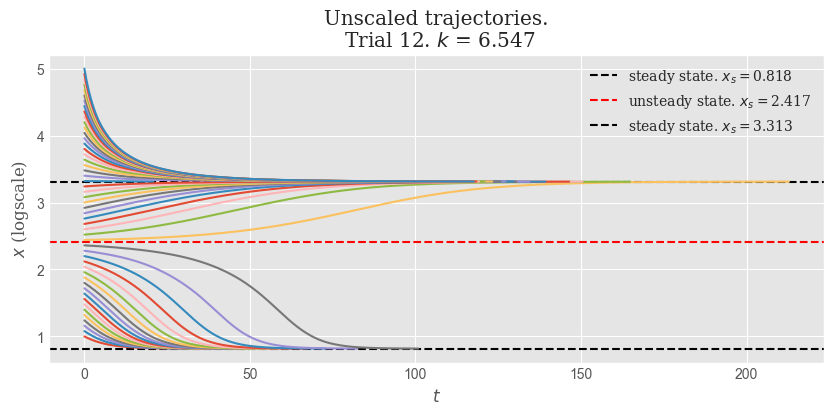

In [9]:
plt.figure(figsize=(10,4))
for xi, ti in tqdm(zip(ki_trials, ki_times)):
    plt.plot(ti,xi,zorder=2)


for idx,xsi in enumerate(budworm_steady_states(ki,r=0.56)):
    label = rf"steady state. $x_s=${xsi:.3f}"
    color = 'black'
    if idx ==1:
        label = rf"unsteady state. $x_s=${xsi:.3f}"
        color = 'red'

    plt.axhline(
        xsi,
        xmin=0,
        c=color,
        linestyle="--",
        label=label,
        zorder=1
    )


plt.legend(prop={'family':'serif'})
# plt.yscale('log')
plt.ylabel(r"$x$ (logscale)", family='serif')
plt.xlabel(r"$t$")
plt.title("Unscaled trajectories.\n" + rf" Trial {trial}. $k$ = {ki:.3f}", family='serif')
if savefigs:
    file_name = f"unscaled_trajectories_k_{ki:.2f}_num_x0_{len(xs)}.pdf"
    plt.savefig(folder+file_name)

plt.show()


## Apply universal scaling to range $(0,1)$ for all trials in $k_i$

In [10]:
scaler = MinMaxScaler()

scaler.fit(np.concatenate(ki_trials).reshape(-1,1))

scaled_trials = [
    scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in ki_trials
]

In [11]:
scaled_steady_states = scaler.transform(np.array(budworm_steady_states(ki,r=0.56)).reshape(-1,1)).reshape(-1)

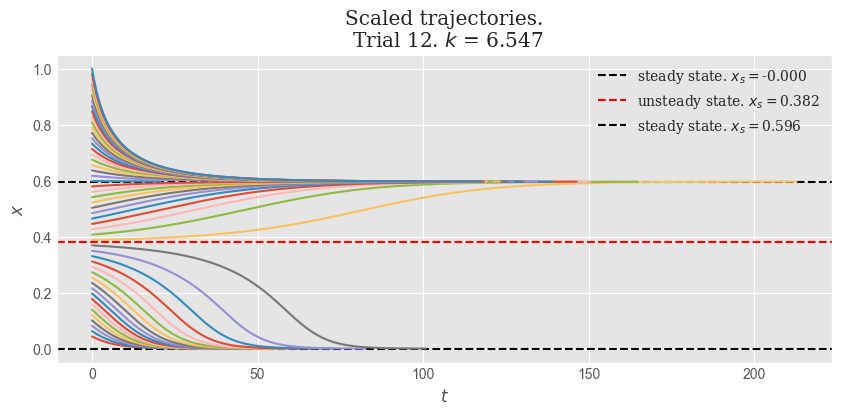

In [12]:
plt.figure(figsize=(10,4))
for xi, ti in zip(scaled_trials, ki_times):
    plt.plot(ti,xi)

for idx,xsi in enumerate(scaled_steady_states):
    label = rf"steady state. $x_s=${xsi:.3f}"
    color = 'black'
    if idx ==1:
        label = rf"unsteady state. $x_s=${xsi:.3f}"
        color = 'red'

    plt.axhline(
        xsi,
        xmin=0,
        c=color,
        linestyle="--",
        label=label,
        zorder=1
    )

plt.legend(prop={'family':'serif'})
plt.ylabel(r"$x$ ", family='serif')
plt.xlabel(r"$t$")
plt.title("Scaled trajectories.\n" + rf" Trial {trial}. $k$ = {ki:.3f}", family='serif')

plt.show()

# Determine bounds for f based on true f

In [13]:
from data.budworm import f_true

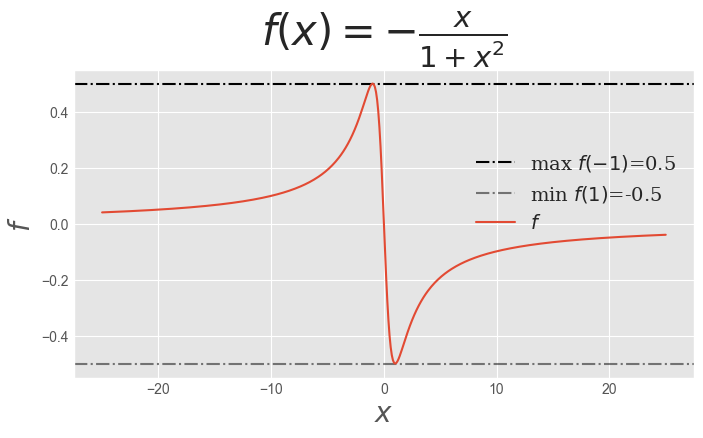

In [14]:
plt.figure(figsize=(8,4))
xlin = np.linspace(-25,25, 501)
plt.title(r"$f(x) = - \frac{x}{1+x^2}$",size=30)
plt.ylabel(r"$f$",size=20)
plt.xlabel(r"$x$",size=20)
plt.axhline(f_true(-1),linestyle='-.',c='black', label=rf"max $f(-1)$={f_true(-1)}")
plt.axhline(f_true(1),linestyle='-.',c='black',alpha=0.5, label=rf"min $f(1)$={f_true(1)}")
plt.plot(xlin, f_true(xlin),label=r'$f$')
plt.legend(prop={'family':'serif','size':14},loc='right',
           bbox_to_anchor=(1.0, 0.6))
plt.show()

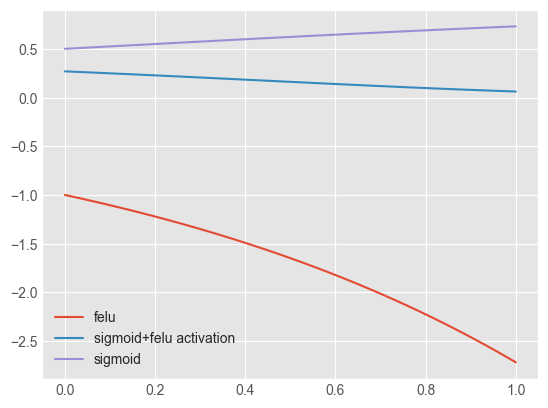

In [15]:
def sigmoid(x):
    return 1/ (1+np.exp(-x))

xlin=np.linspace(0,1,101)
plt.plot(xlin, -np.exp(xlin), label="felu")
plt.plot(xlin, sigmoid(-np.exp(xlin)), label='sigmoid+felu activation')
plt.plot(xlin, sigmoid(xlin), label='sigmoid')
plt.legend()
plt.show()

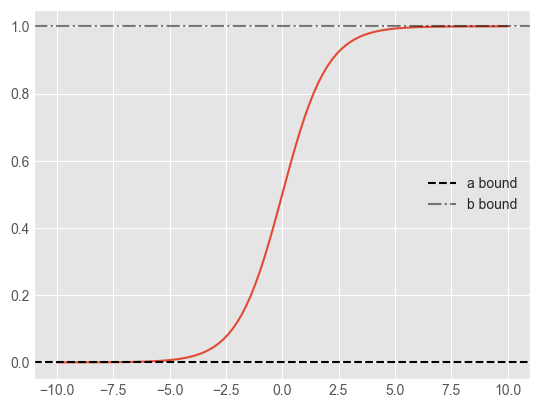

In [16]:
a = 0
b=1
xlin2 = np.linspace(-10,10,101)
plt.plot(xlin2,a+ (b-a)*sigmoid(xlin2))
plt.axhline(a,linestyle='--', c='black',label="a bound")
plt.axhline(b,linestyle='-.',c='black', alpha=0.5, label="b bound")
plt.legend()
plt.show()

## Train with regular $f$ (`Felu`) and bounded $f$ (`FeluSimoid`)

In [17]:
from stabnode.node import Gelu, Felu, FeluSigmoid, StabNODE
from stabnode.utils import set_global_seed, _load_loop_wrapper
from torchode import solve_ivp

import torch
import torch.nn as nn

import time

seed = 1234
set_global_seed(seed=seed)

device= 'cpu'

### Bounded $f$, `FeluSigmoid`

In [18]:
g = Gelu(2, 1, 4)
f = FeluSigmoid(1,1,4,lower_bound=-0.5, upper_bound=-0.1)

model = StabNODE(f,g).to(device=device)

In [19]:
def control_func(t):
    return torch.tensor(smooth_k_torch(t),dtype=torch.float32,device=device).unsqueeze(0)

In [20]:
# Create training dataset
from typing import List

class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials:List, t_trials:List,):
        self.x_trials = x_trials             # shape [T_total, d]
        self.t_trials = t_trials              # shape [T_total]

    def __len__(self):
        return len(self.x_trials) 

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {self.__len__()}."
            )
        
        
        Xi = self.x_trials[idx]                                          
        ti = self.t_trials[idx]  
        x0 = Xi[0]           

        return Xi,ti,x0

In [21]:
scaled_trials_torch = [
    torch.tensor(trial,dtype=torch.float32, device=device)
    for trial in scaled_trials
]

ki_times_torch = [
    torch.tensor(time_i,dtype=torch.float32, device=device)
    for time_i in ki_times
]


dataset = TrialsDataset(scaled_trials_torch,ki_times_torch)

In [22]:
train_loader = torch.utils.data.DataLoader(dataset,shuffle=True, batch_size=1,num_workers=0)

In [23]:
n_epochs = 20
lr = 1e-2
show_progress = True
solve_method = 'dopri5'
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
# control_func = smooth_k
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)


loop_wrapper = _load_loop_wrapper(show_progress)
loop_wrapper2 = _load_loop_wrapper(True)

model.train()
losses = []
times = []
status = []

Xi_epoch_predictions = []
Tis_epoch = []
for epoch in loop_wrapper(range(n_epochs)):
    t1 = time.time()
    epoch_loss = 0.0
    num_batches = 0
    epoch_losses = []

    Xi_predictions = []
    Tis = []
    for Xi, Ti, x0i in loop_wrapper2(train_loader):
        Xi = Xi.squeeze() # [batch, time, dim]
        Ti = Ti.squeeze()
        x0i = x0i.reshape(-1,1)

        if not x0i.requires_grad:
            x0i = x0i.clone().detach().requires_grad_()


        opt.zero_grad()

        sol = solve_ivp(
            f=lambda t, x: model(t, x, control_func),
            y0=x0i,
            t_eval=Ti,
            method=solve_method
        )

        status.append(sol.status)
        Xi_pred = sol.ys.squeeze()
        Xi_predictions.append(Xi_pred)
        Tis.append(Ti)
        loss = loss_criteria(Xi_pred, Xi)

        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

    Xi_epoch_predictions.append(Xi_predictions)
    Tis_epoch.append(Tis)
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch}: Loss: {avg_loss}")
    losses.append(avg_loss)

    t2 = time.time()
    times.append(t2 - t1)    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 0: Loss: 0.2851562516343798


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1: Loss: 0.07192804492717865


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2: Loss: 0.06884100945556865


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3: Loss: 0.06839733002889975


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4: Loss: 0.07140607565787493


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5: Loss: 0.0722394437236967


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 6: Loss: 0.0718884642655943


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 7: Loss: 0.06618489222783669


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 8: Loss: 0.07237670514002151


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 9: Loss: 0.0721788677186066


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 10: Loss: 0.07074294759727576


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 11: Loss: 0.07046447977350623


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 12: Loss: 0.06815103937269133


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 13: Loss: 0.07128828574045032


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 14: Loss: 0.07135792607989382


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 15: Loss: 0.07163717597723007


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 16: Loss: 0.07263597678940963


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 17: Loss: 0.07482381701907691


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 18: Loss: 0.06850595025382206


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 19: Loss: 0.07906785103328087


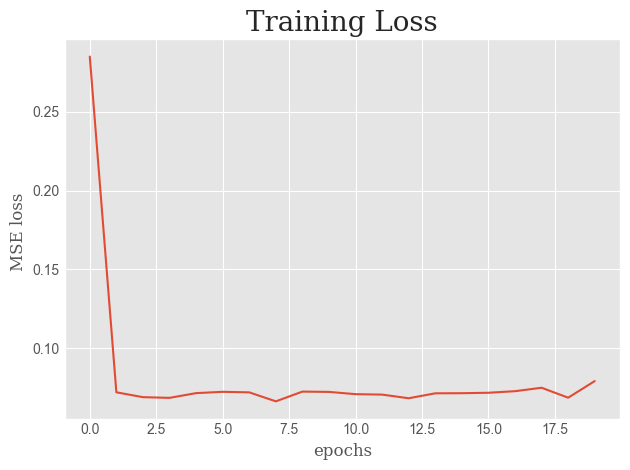

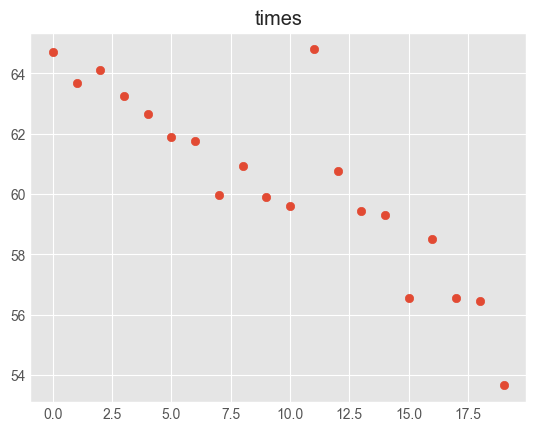

In [24]:
plt.plot(losses)
plt.title('Training Loss', family='serif', size=20)
plt.xlabel("epochs", family='serif')
plt.ylabel("MSE loss ", family='serif')
# plt.yscale('log')
plt.tight_layout()
if savefigs:
    file_name = "loss_k_{:.2f}_epoch_{}_num_x0_{}_lr_{}".format(
        ki,n_epochs, len(xs), lr
    )

    file_name += "_f"
    for key,val in f.args.items():
        file_name += "_{}_{}".format(key,val)

    file_name += "_g"
    for key,val in g.args.items():
        file_name += "_{}_{}".format(key,val)

    file_name +=".pdf"
    plt.savefig(folder+file_name)
plt.show()


plt.scatter(np.arange(len(times)),times)
plt.title('times')
plt.show()

## Evaluate model to determined trajectories

In [25]:
g_eval = model.g.eval()
f_eval = model.f.eval()

model_eval = StabNODE(f_eval,g_eval)

In [26]:
cols = 5
rows = int(np.ceil(len(dataset)/cols))



  0%|          | 0/51 [00:00<?, ?it/s]

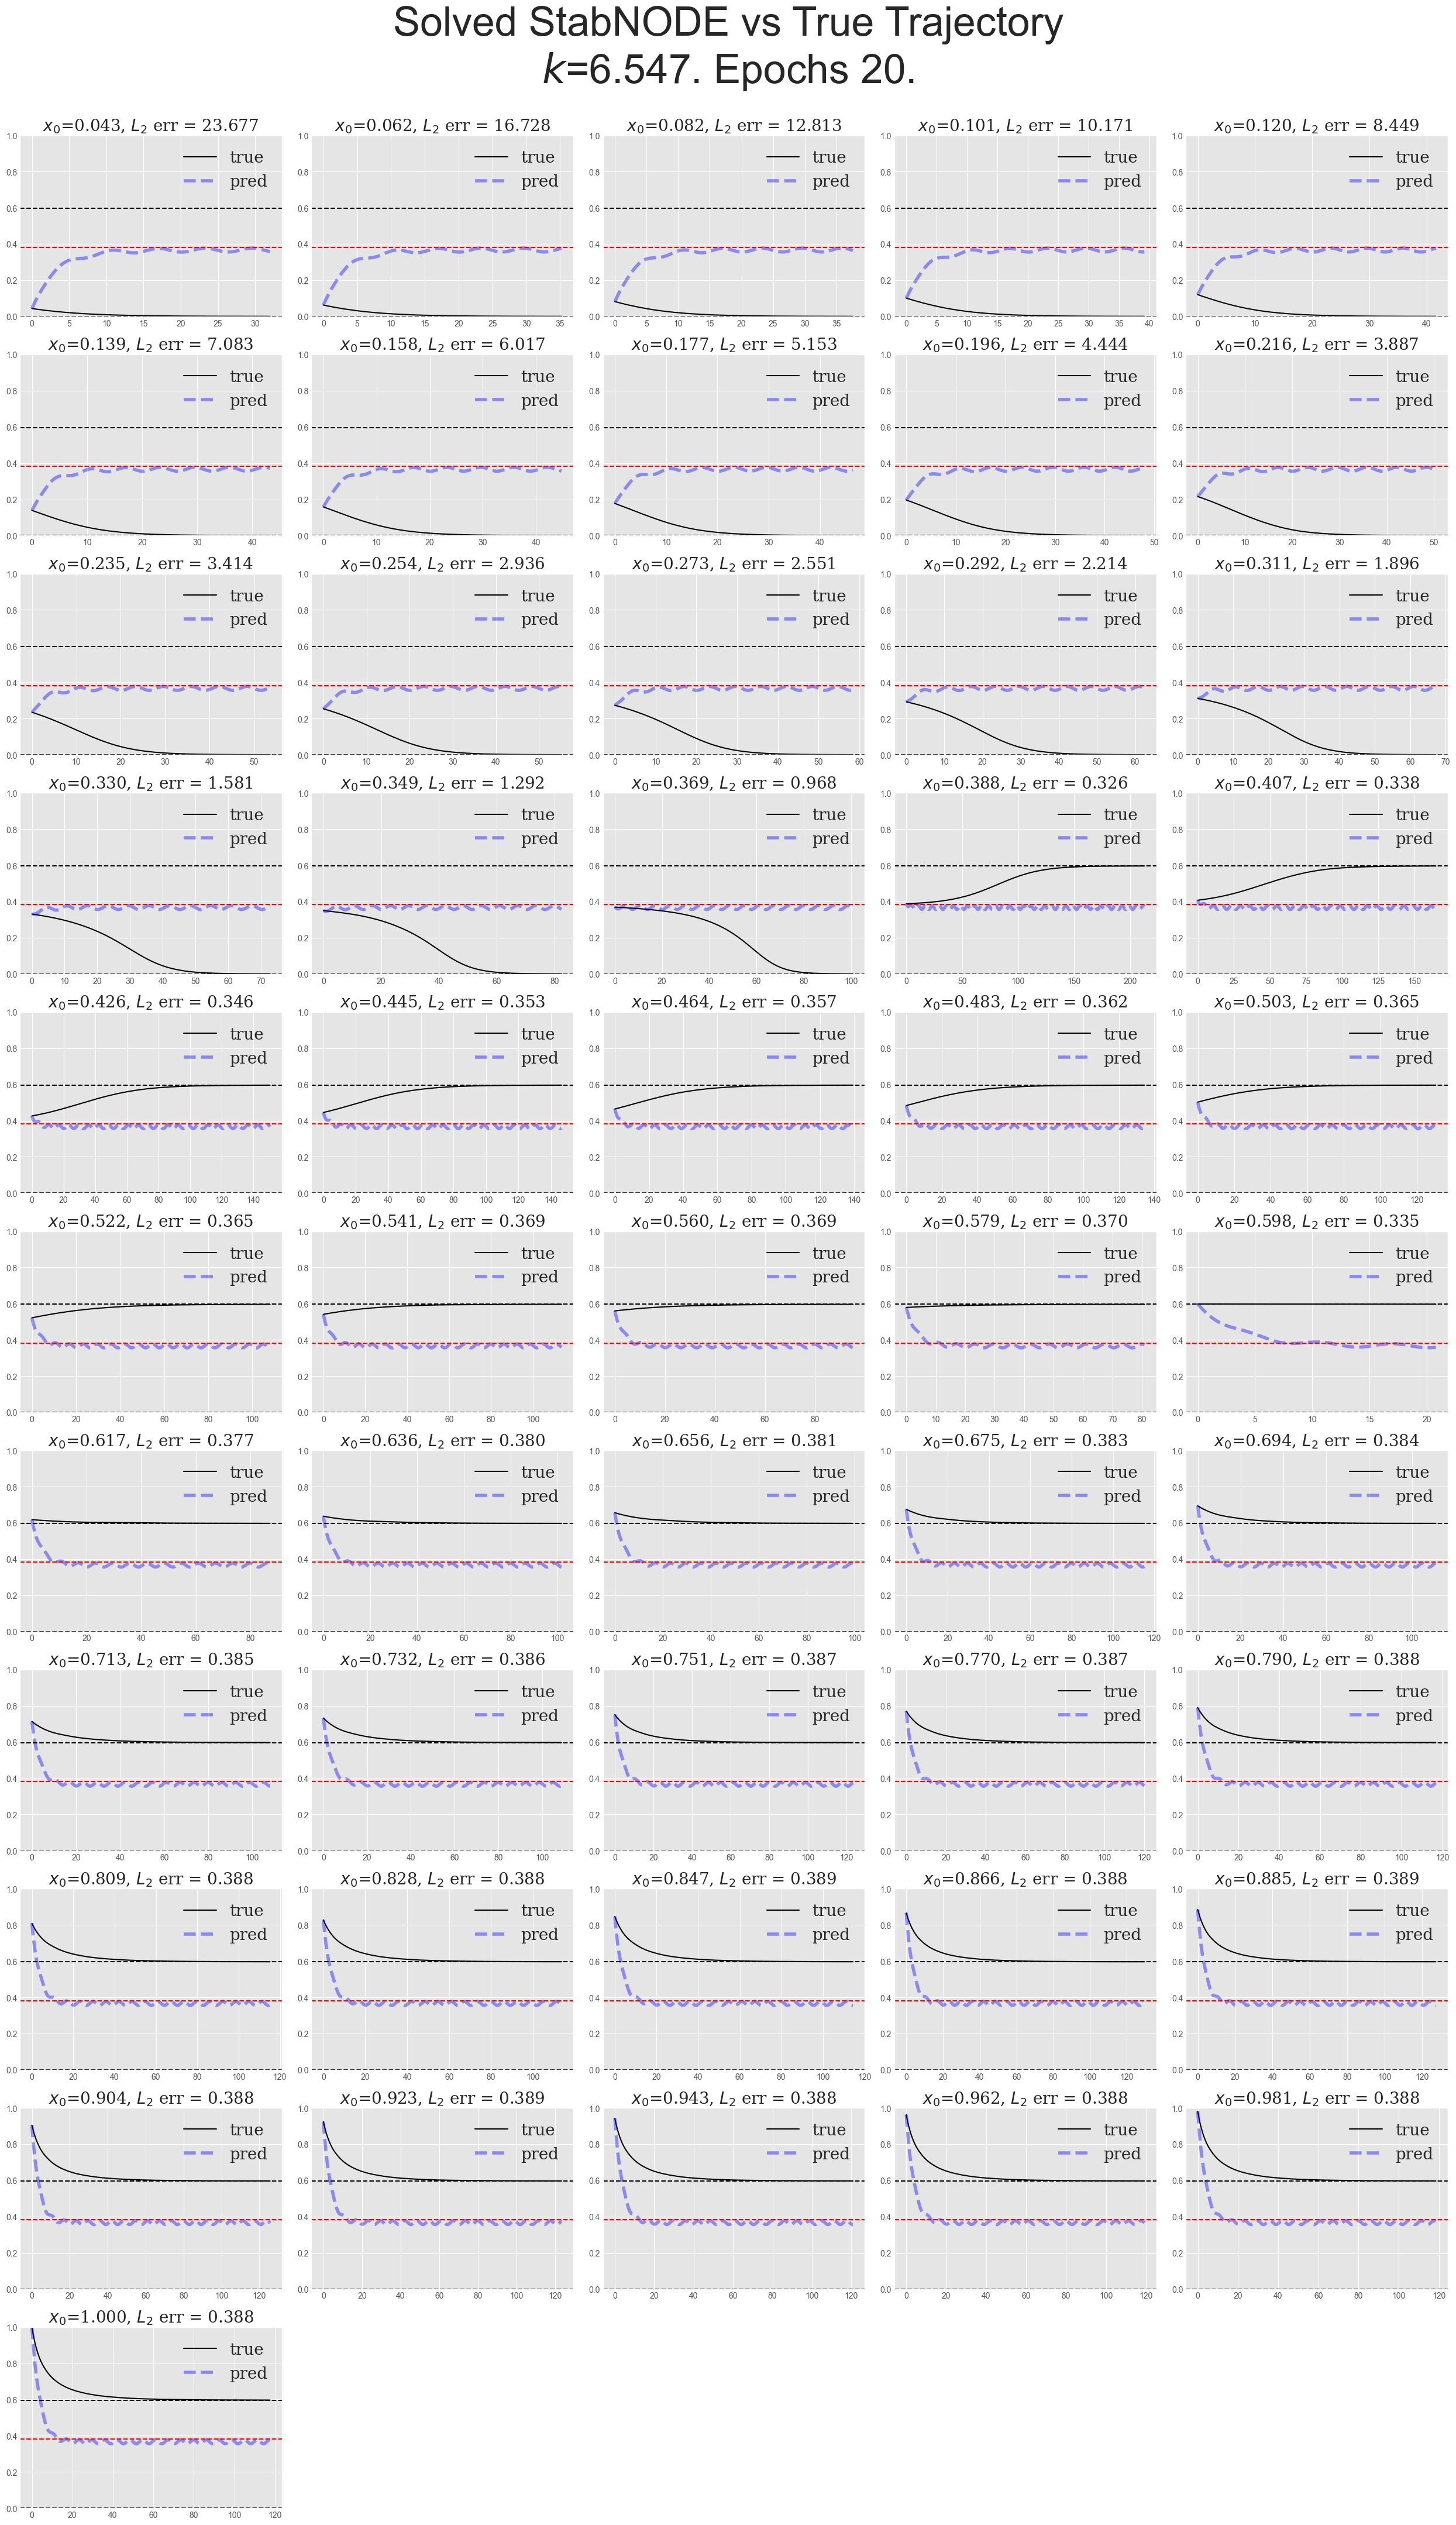

In [27]:

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()

with torch.no_grad():
    for idx in tqdm(range(len(dataset))):
        ax = axs[idx]
        xi, ti, x0i = dataset[idx]

        sol = solve_ivp(
            f=lambda t, x: model_eval(t, x, control_func),
            y0=x0i.reshape(-1,1),
            t_eval=ti,
            method=solve_method
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i:.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        for idx,xsi in enumerate(scaled_steady_states):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(dataset), rows*cols):
        fig.delaxes(axs[idx])

plt.tight_layout(rect=[0, 0, 1, 0.94])  
plt.suptitle("Solved StabNODE vs True Trajectory\n"+rf"$k$={ki:.3f}. Epochs {n_epochs}.",size=50)
if savefigs:
    file_name = "traj_vs_stabnode_k_{:.2f}_epoch_{}_num_x0_{}_lr_{}".format(
        ki,n_epochs, len(xs), lr
    )

    file_name += "_f"
    for key,val in f.args.items():
        file_name += "_{}_{}".format(key,val)

    file_name += "_g"
    for key,val in g.args.items():
        file_name += "_{}_{}".format(key,val)

    file_name +=".pdf"
    plt.savefig(folder+file_name)
plt.show()


## Plot dynamics of $f$ and $g$ 

In [28]:
from data.budworm import f_true, g_true


In [29]:
x_lin = np.linspace(0,1,101)

with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin,dtype=torch.float32)
    f_pred = f_eval(x_lin_torch)
    k_torch = torch.tensor(ki,dtype=torch.float32).reshape(-1,1)
    u_expanded = k_torch.expand(x_lin_torch.shape[0], -1)


    print(x_lin_torch.reshape(-1,1).shape, k_torch.shape)
    g_pred = g_eval(x_lin_torch.reshape(-1,1), u_expanded)

torch.Size([101, 1]) torch.Size([1, 1])


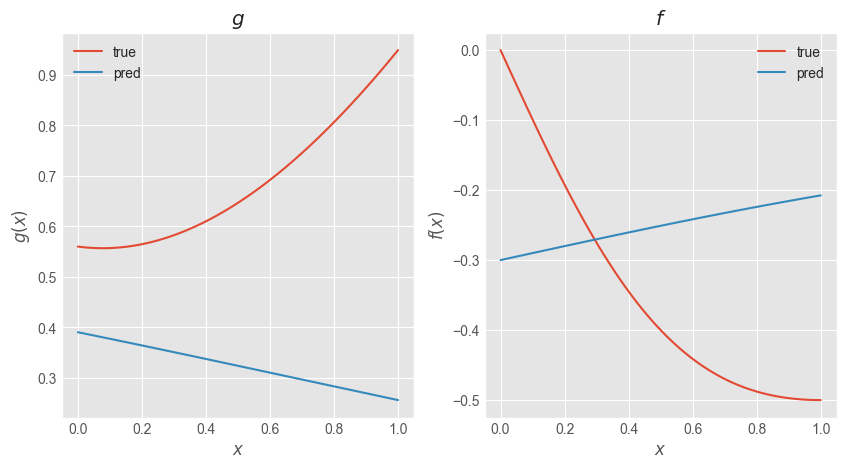

In [30]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(x_lin, g_true(x_lin,ki,r=0.56),label='true')
ax1.plot(x_lin_torch, g_pred, label='pred')
ax1.set_title(r"$g$")
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$g(x)$")
ax1.legend()

ax2.plot(x_lin, f_true(x_lin), label='true')
ax2.plot(x_lin_torch, f_pred, label='pred')
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$f(x)$")
ax2.set_title(r"$f$")
ax2.legend()
plt.show()

In [31]:
show = True
for a,b,c in train_loader:
    if show:
        print(a.shape,b.shape, c.shape)
        print(a.squeeze().shape, b.squeeze().shape, c.reshape(-1,1).shape)
        show=False

torch.Size([1, 497]) torch.Size([1, 497]) torch.Size([1])
torch.Size([497]) torch.Size([497]) torch.Size([1, 1])


In [32]:
file_name = "traj_vs_stabnode_k_{:.2f}_epoch_{}_num_x0_{}_lr_{}".format(
    ki,n_epochs, len(xs), lr
)

file_name += "_f"
for key,val in f.args.items():
    file_name += "_{}_{}".format(key,val)

file_name += "_g"
for key,val in g.args.items():
    file_name += "_{}_{}".format(key,val)

file_name +=".pdf"

In [33]:
file_name


'traj_vs_stabnode_k_6.55_epoch_20_num_x0_51_lr_0.01_f_dim_in_1_dim_out_1_hidden_dim_4_lower_bound_-0.5_upper_bound_-0.1_g_dim_in_2_dim_out_1_hidden_dim_4.pdf'

In [34]:
"figures/"+file_name

'figures/traj_vs_stabnode_k_6.55_epoch_20_num_x0_51_lr_0.01_f_dim_in_1_dim_out_1_hidden_dim_4_lower_bound_-0.5_upper_bound_-0.1_g_dim_in_2_dim_out_1_hidden_dim_4.pdf'

In [35]:
f.args

{'dim_in': 1,
 'dim_out': 1,
 'hidden_dim': 4,
 'lower_bound': -0.5,
 'upper_bound': -0.1}

In [36]:
g.args

{'dim_in': 2, 'dim_out': 1, 'hidden_dim': 4}

In [37]:
f.args.keys()

dict_keys(['dim_in', 'dim_out', 'hidden_dim', 'lower_bound', 'upper_bound'])

In [38]:
test = ""
for key, value in f.args.items():
    test += "_{}_{}".format(key,value)


In [39]:
test

'_dim_in_1_dim_out_1_hidden_dim_4_lower_bound_-0.5_upper_bound_-0.1'